In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import umap
from sklearn.mixture import GaussianMixture
from scipy import stats
import seaborn as sns
import pandas as pd

from scipy.stats import zscore

from numpy.random import multivariate_normal
from scipy.spatial.distance import mahalanobis
from scipy.spatial.distance import euclidean
from sklearn.decomposition import PCA
from sklearn import preprocessing

import scipy.cluster.hierarchy as sch


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"

# Load data

In [2]:
# load (shuffled) list of unique IDs for the 468202 light curve segments. Format: observationID_segmentIndex,
# i.e. ['96701-01-48-00_3','20402-01-02-02_122','70703-01-01-000_1420', ...]
with open('{}/468202_len128_s2_4cad_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
    
# load observation classifications from Huppenkothen+2017, there are just over 200
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))

# Load component labels under the Gaussian mixture model with 500 components for the 468202 segments
# i.e. array([458, 278,  30, ..., 358, 450, 400])
with open('{}/shape_moments_GM500_labels.pkl'.format(data_dir), 'rb') as f:
    shape_moments_GM500_labels = pickle.load(f)

# Build a dataframe containing counts of light curve segments in each Gaussian mixture component for each observation
intended shape of the data frame: [1738, 500]

In [3]:
# make a list of observation ids; for each of the 468202 segments, get the ID of the observation that it comes from
#i.e. ['96701-01-48-00','20402-01-02-02', '70703-01-01-000',
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # gets rid of the within-observation segment indices and creates a degenerate list of observation IDs

In [4]:
# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

In [5]:
# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_500 == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_500 = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_500[ObID] = [shape_moments_GM500_labels[ind] for ind in Indices]

In [6]:
# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_500 = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_500),len(np.unique(shape_moments_GM500_labels)))), index=np.unique(seg_ObIDs), columns=list(range(500)), dtype=int)

In [7]:
# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_500.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_500.loc[ObID][comp_id] = comp_count
obs_component_counts_df_500

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
10258-01-01-00,0,0,8,0,0,0,0,0,0,0,...,0,2,0,12,0,0,0,0,0,0
10258-01-02-00,0,0,30,0,0,0,0,0,0,0,...,0,6,0,8,0,0,0,0,0,0
10258-01-03-00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
10258-01-04-00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,0,0,0
10258-01-05-00,14,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96701-01-51-00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
96701-01-51-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96701-01-52-00,12,0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
#sanity check; count of the number of segments in each Gaussian component, as returned by the Gaussian_mixture_model.predict() method,
#matches the  count in the columns of the data frame, so we transferred the counts from list to dataframe successfully
print((np.unique(shape_moments_GM500_labels, return_counts= True)[1] == obs_component_counts_df_500.sum().values).all())
#total number of segment counts matches the size of our dataset
print(obs_component_counts_df_500.sum().sum())
#each component has at least 59 counts in it, so I didn't mis-name "shape_moments_GM114_labels" as "shape_moments_GM500_labels" 
print(obs_component_counts_df_500.sum().values.min())

True
468202
59


# Prepare normalised/standardised versions of the data frame

In [9]:
# apply mean centering and variance scaling to values in each row of the data frame
row_standardised_obs_component_counts_df_500 = pd.DataFrame(preprocessing.scale(obs_component_counts_df_500, axis=1), index=np.unique(seg_ObIDs), columns=list(range(500)))
row_standardised_obs_component_counts_df_500

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
10258-01-01-00,-0.192533,-0.192533,0.613888,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,...,-0.192533,0.009072,-0.192533,1.017098,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533,-0.192533
10258-01-02-00,-0.189176,-0.189176,2.804109,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,...,-0.189176,0.409481,-0.189176,0.609034,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176,-0.189176
10258-01-03-00,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,...,-0.144074,-0.144074,-0.144074,-0.061082,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074,-0.144074
10258-01-04-00,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,...,-0.110966,-0.110966,-0.110966,0.216367,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966,-0.110966
10258-01-05-00,1.349320,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,...,-0.200096,0.021249,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096,-0.200096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,...,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177,-0.099177
96701-01-51-00,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,...,-0.120367,-0.120367,-0.120367,0.407559,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367,-0.120367
96701-01-51-01,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,...,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700,-0.103700
96701-01-52-00,4.811076,-0.136894,3.574083,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,...,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894,-0.136894


In [10]:
# apply mean centering and variance scaling to values in each column of the data frame
column_standardised_obs_component_counts_df_500 = pd.DataFrame(preprocessing.scale(obs_component_counts_df_500, axis=0), index=np.unique(seg_ObIDs), columns=list(range(500)))
column_standardised_obs_component_counts_df_500

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
10258-01-01-00,-0.195880,-0.141515,4.347059,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,0.465093,-0.129721,8.370875,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157
10258-01-02-00,-0.195880,-0.141515,16.983075,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,1.916317,-0.129721,5.496088,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157
10258-01-03-00,-0.195880,-0.141515,-0.247856,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,-0.260519,-0.129721,0.465209,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157
10258-01-04-00,-0.195880,-0.141515,-0.247856,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,-0.260519,-0.129721,4.058694,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157
10258-01-05-00,3.610943,-0.141515,-0.247856,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,0.465093,-0.129721,-0.253487,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,-0.195880,-0.141515,-0.247856,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,-0.260519,-0.129721,-0.253487,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157
96701-01-51-00,-0.195880,-0.141515,-0.247856,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,-0.260519,-0.129721,0.465209,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157
96701-01-51-01,-0.195880,-0.141515,-0.247856,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,-0.260519,-0.129721,-0.253487,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157
96701-01-52-00,3.067111,-0.141515,4.921424,-0.039177,-0.168474,-0.197969,-0.03686,-0.102787,-0.105149,-0.123356,...,-0.074605,-0.260519,-0.129721,-0.253487,-0.100645,-0.061925,-0.142481,-0.042017,-0.133094,-0.059157


In [11]:
# apply min-max normalisation to values in each row of the data frame
from sklearn.preprocessing import Normalizer
normalized_obs_component_counts_df_500 = pd.DataFrame(Normalizer(norm='max').fit_transform(obs_component_counts_df_500), index=np.unique(seg_ObIDs), columns=list(range(500)))
normalized_obs_component_counts_df_500

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
10258-01-01-00,0.000000,0.0,0.062992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.015748,0.0,0.094488,0.0,0.0,0.0,0.0,0.0,0.0
10258-01-02-00,0.000000,0.0,0.236220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.047244,0.0,0.062992,0.0,0.0,0.0,0.0,0.0,0.0
10258-01-03-00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.005714,0.0,0.0,0.0,0.0,0.0,0.0
10258-01-04-00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.022989,0.0,0.0,0.0,0.0,0.0,0.0
10258-01-05-00,0.133333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.019048,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96701-01-50-01,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
96701-01-51-00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0
96701-01-51-01,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
96701-01-52-00,0.279070,0.0,0.209302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


# perform agglomerative clustering of the observations (visualised by dendograms), using a couple of different agglomeration methods, distance metrics and the different data frames

Method : ward, Metric : euclidean, Data : raw_counts


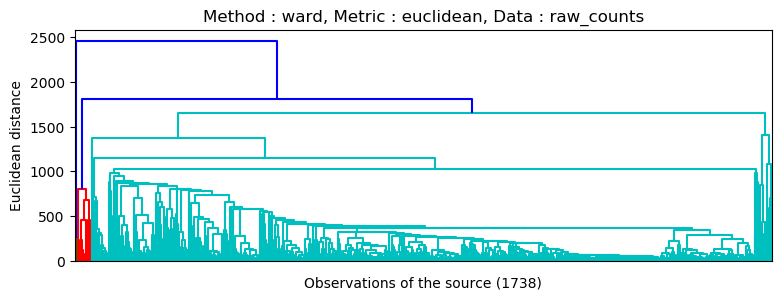

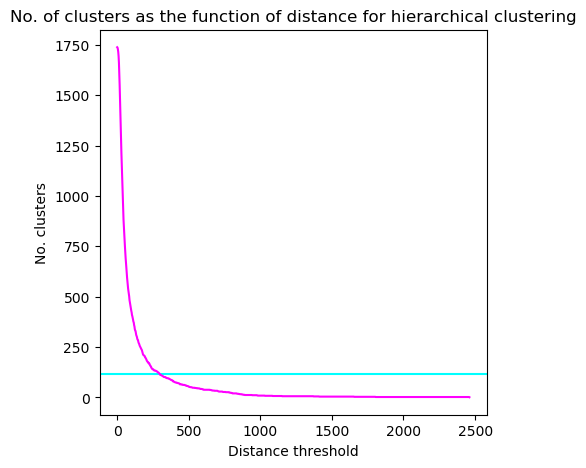

Method : complete, Metric : euclidean, Data : raw_counts


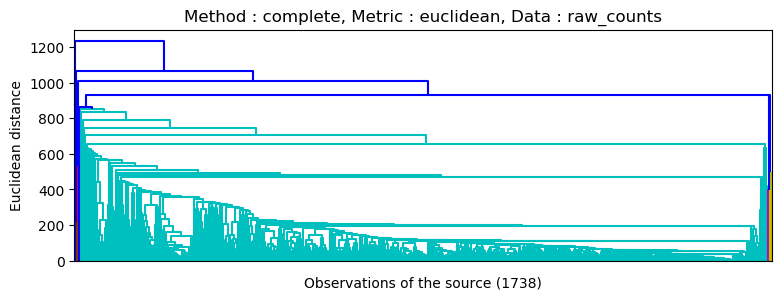

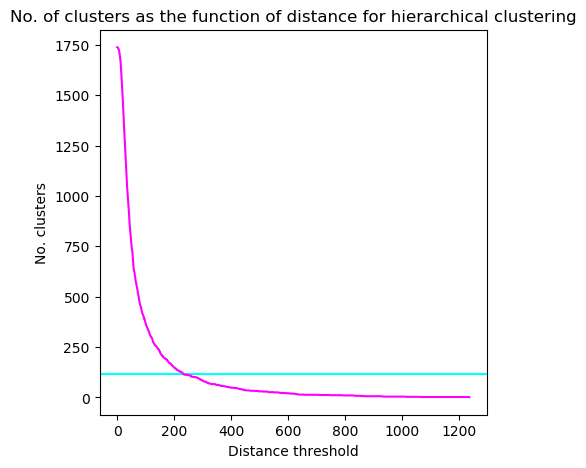

Method : complete, Metric : cosine, Data : raw_counts


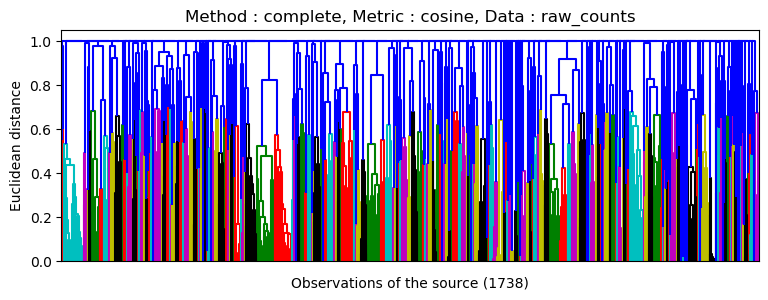

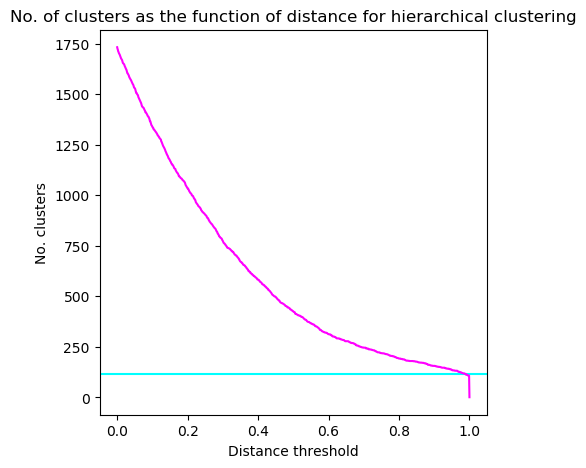

Method : average, Metric : euclidean, Data : raw_counts


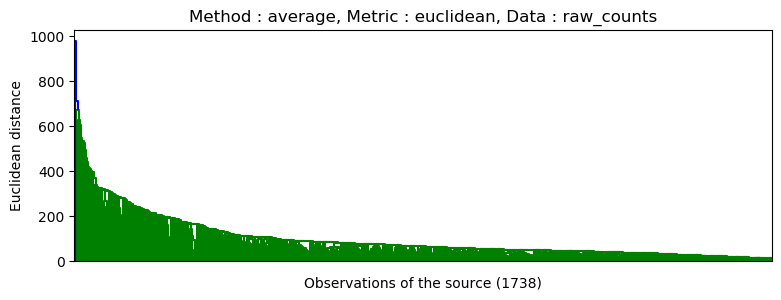

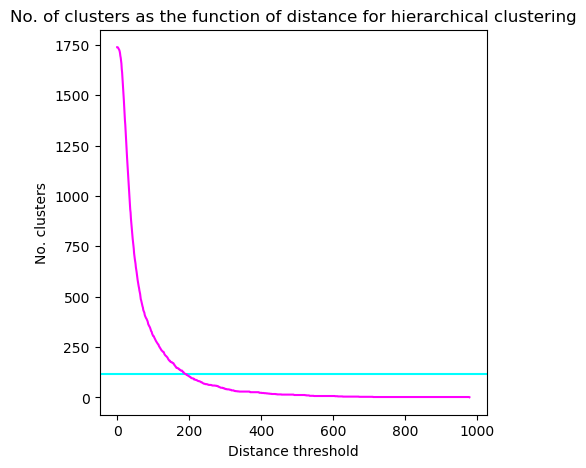

Method : average, Metric : cosine, Data : raw_counts


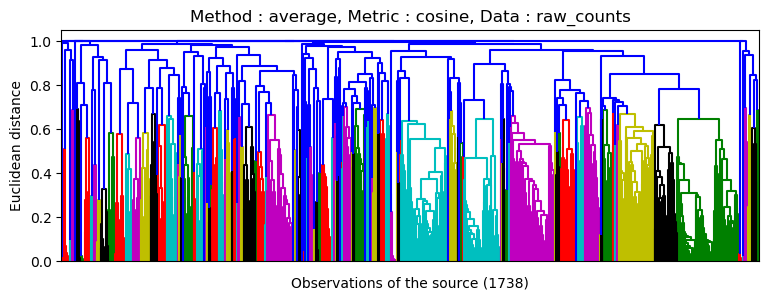

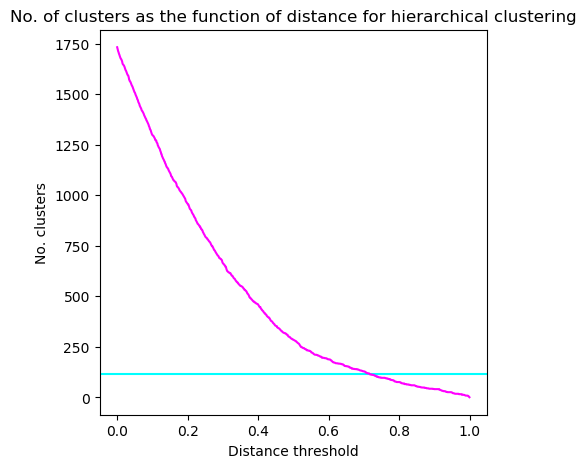

Method : ward, Metric : euclidean, Data : row_standardised


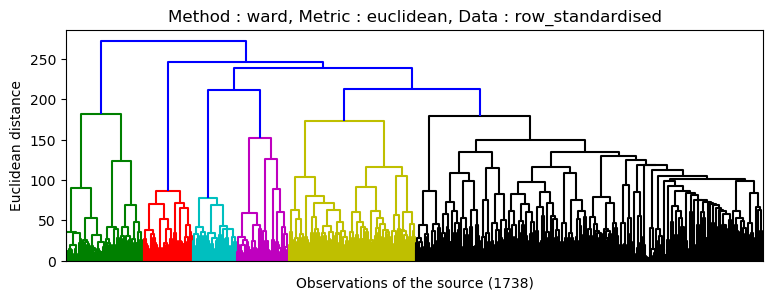

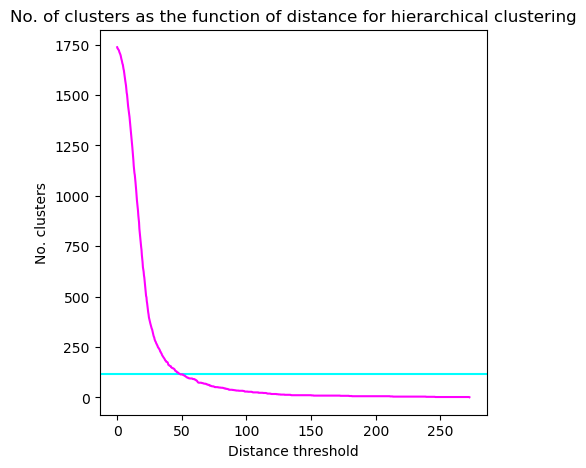

Method : complete, Metric : euclidean, Data : row_standardised


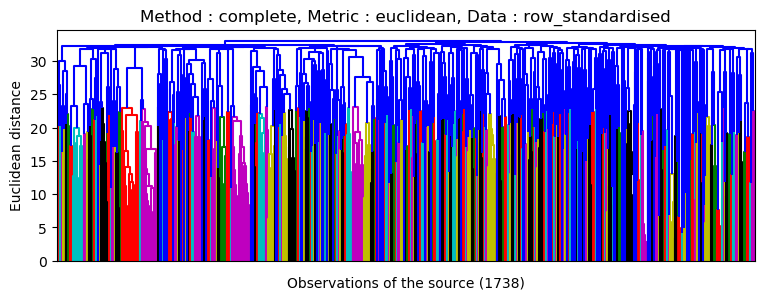

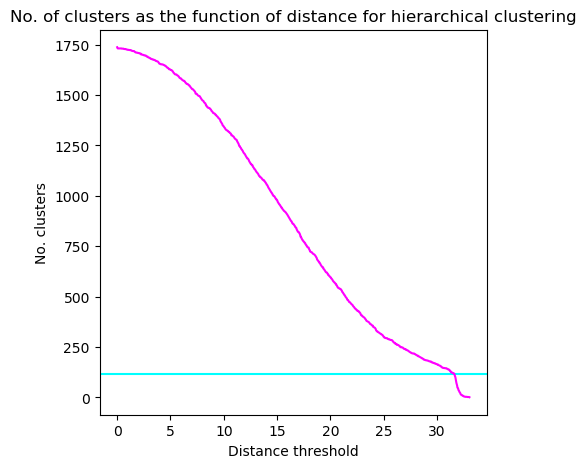

Method : complete, Metric : cosine, Data : row_standardised


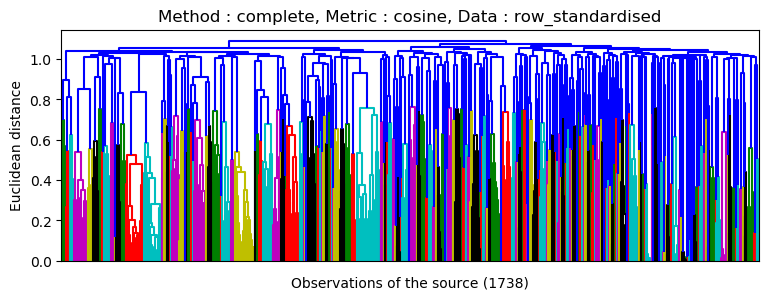

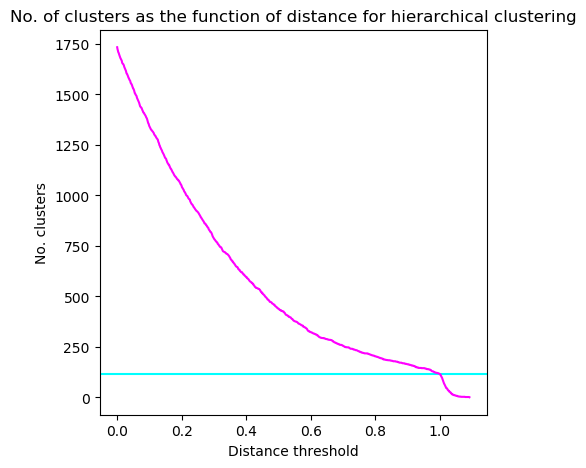

Method : average, Metric : euclidean, Data : row_standardised


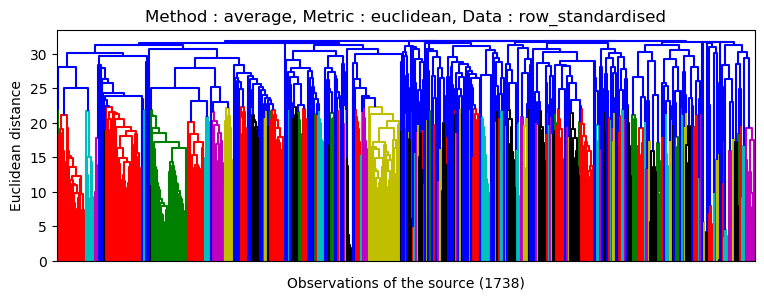

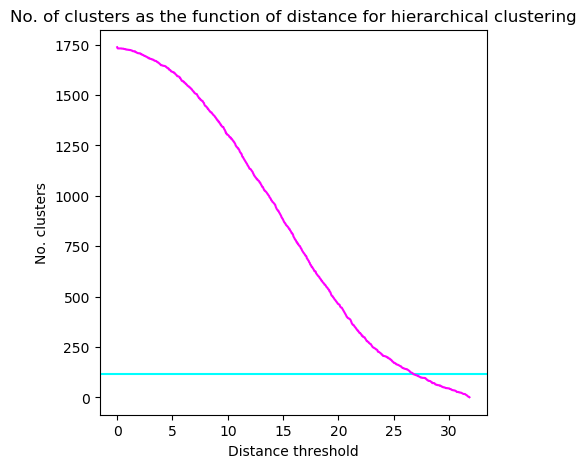

Method : average, Metric : cosine, Data : row_standardised


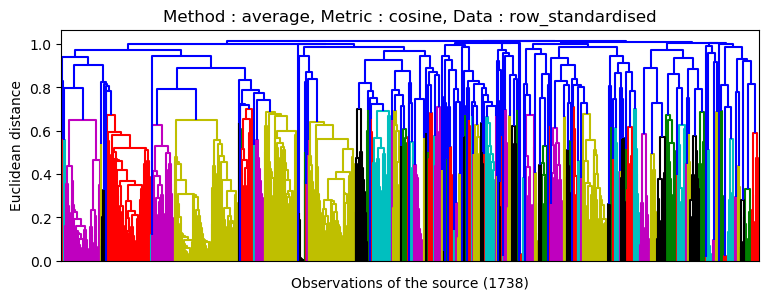

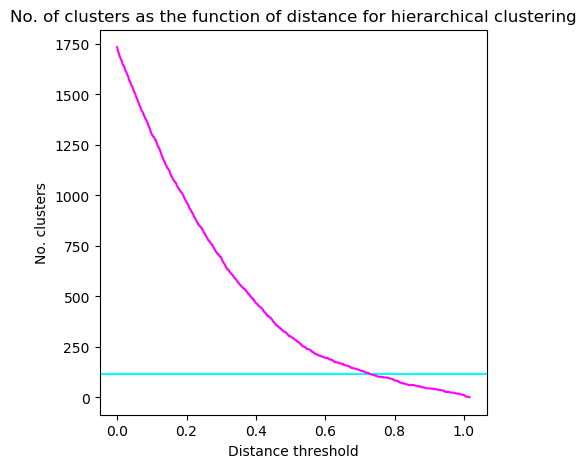

Method : ward, Metric : euclidean, Data : column_standardised


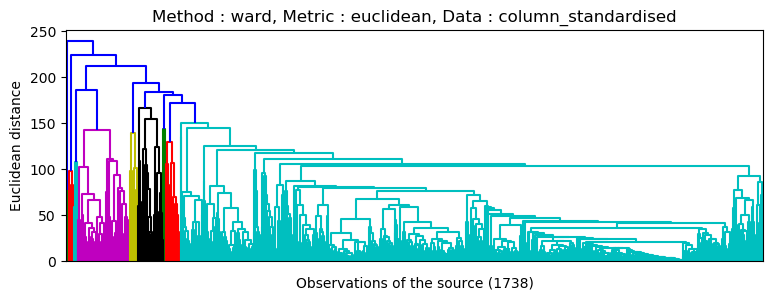

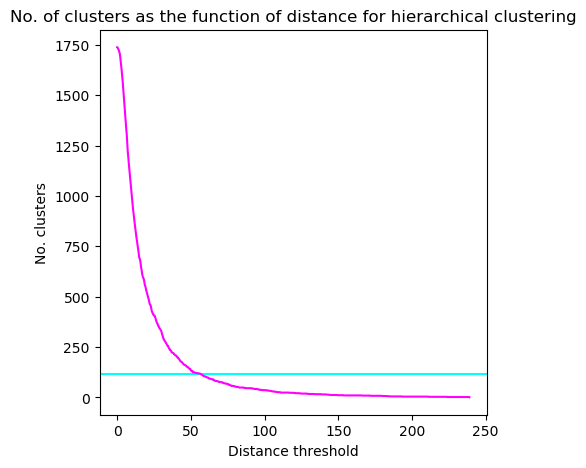

Method : complete, Metric : euclidean, Data : column_standardised


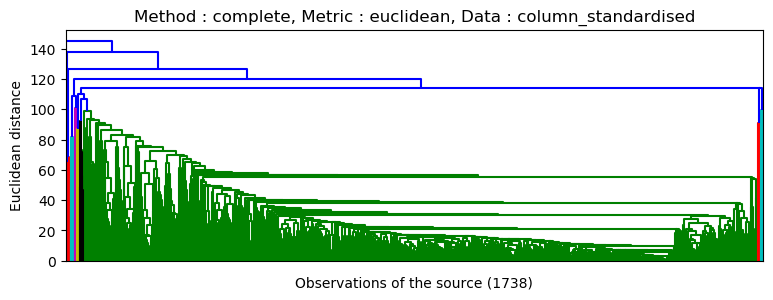

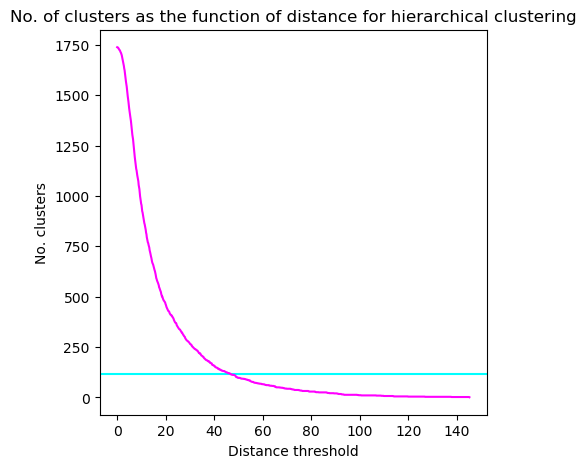

Method : complete, Metric : cosine, Data : column_standardised


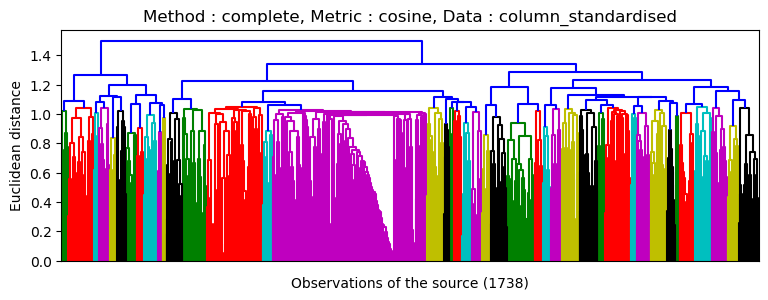

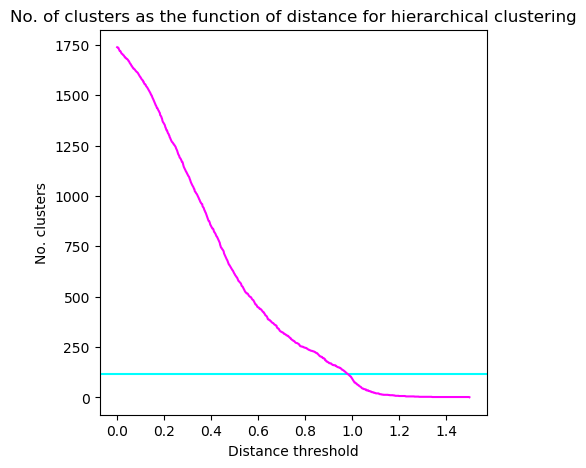

Method : average, Metric : euclidean, Data : column_standardised


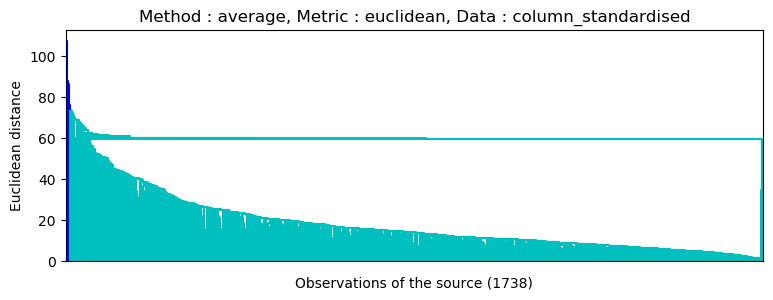

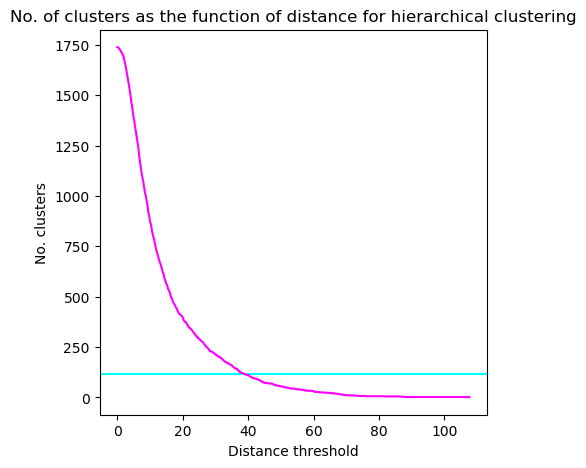

Method : average, Metric : cosine, Data : column_standardised


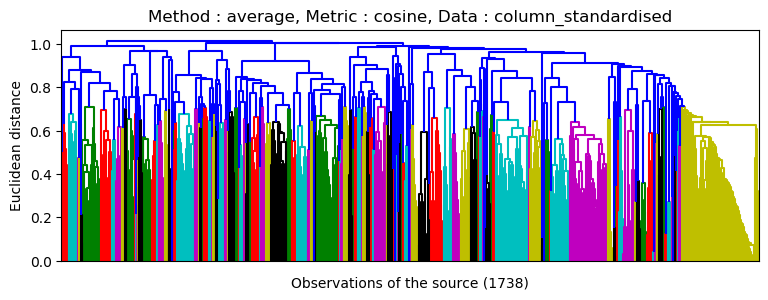

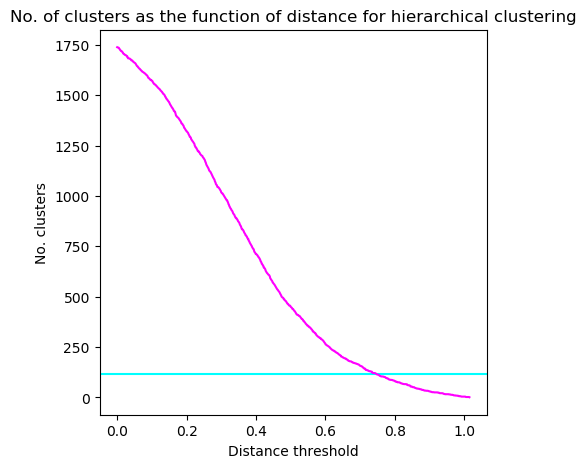

Method : ward, Metric : euclidean, Data : row_normalised


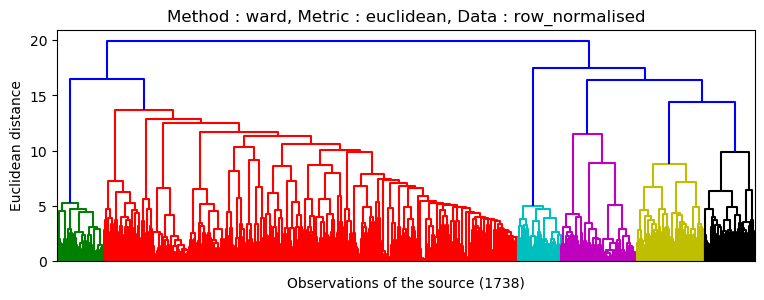

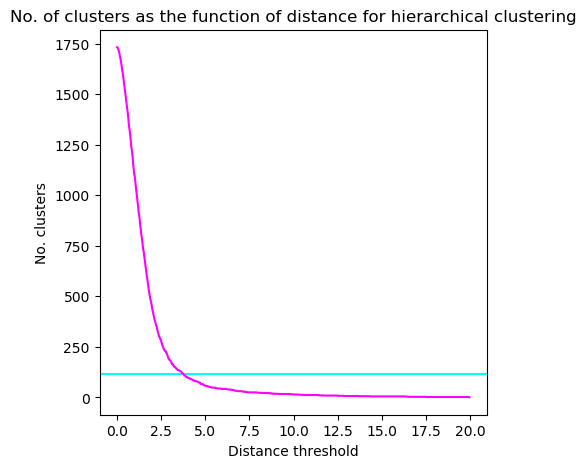

Method : complete, Metric : euclidean, Data : row_normalised


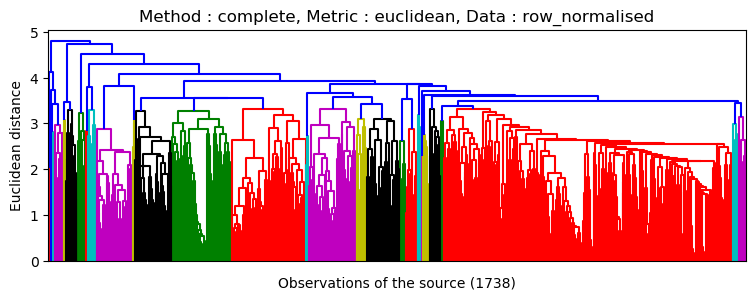

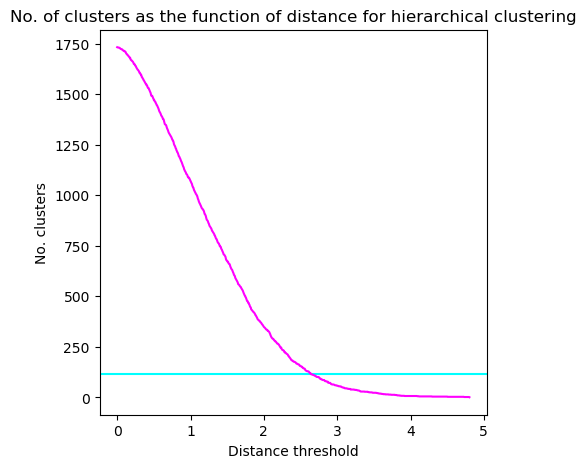

Method : complete, Metric : cosine, Data : row_normalised


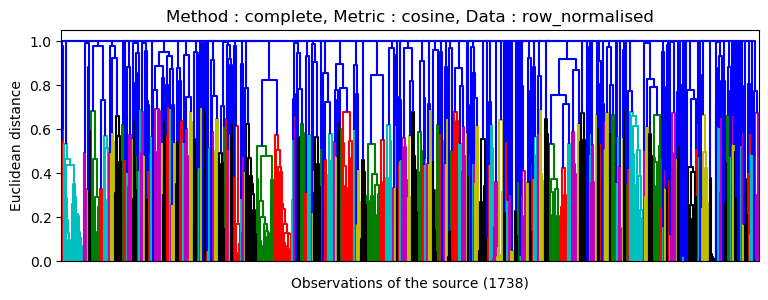

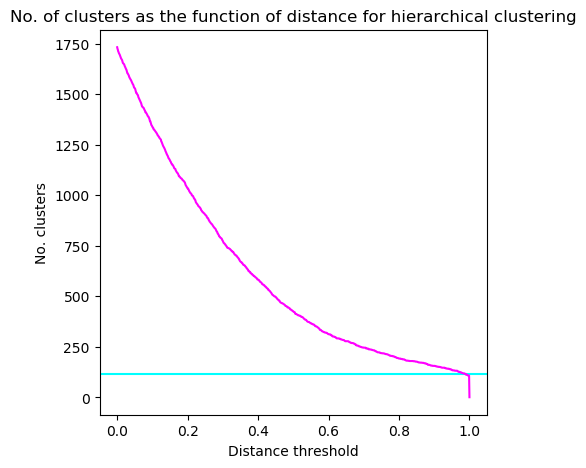

Method : average, Metric : euclidean, Data : row_normalised


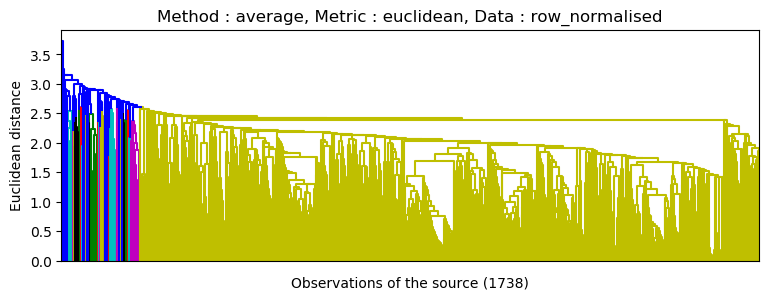

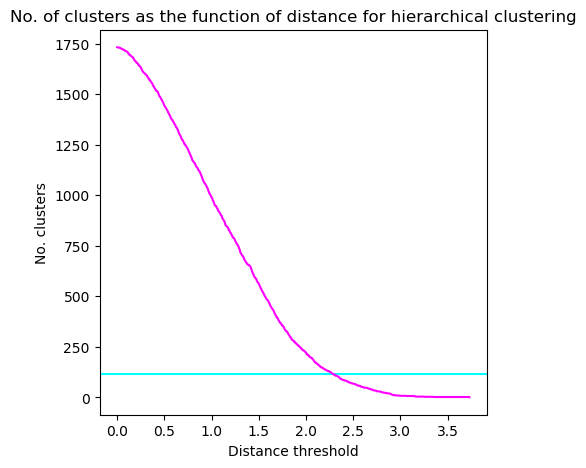

Method : average, Metric : cosine, Data : row_normalised


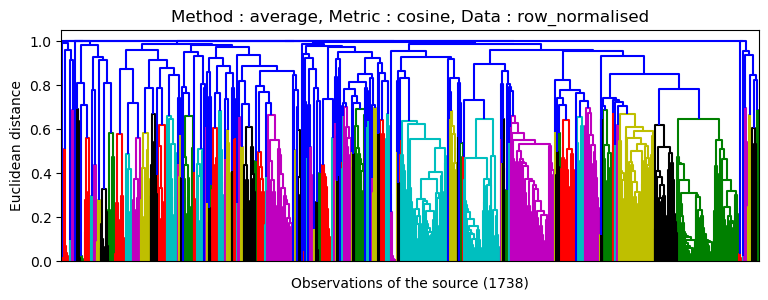

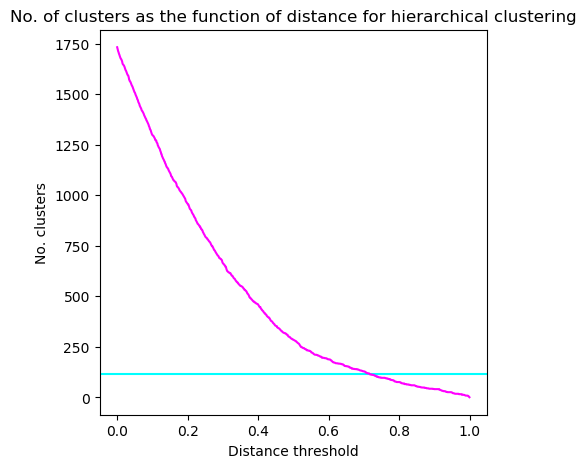

In [12]:
def plot_denogram_and_no_clusters_curve(method, metric, data_set, data_set_name):
    """
    method : how are the clusters agglomerated, eg. merge the two nearest clusters w.r.t the furthest data point("complete"), 
                cluster centroid ("average"), minimum variance ("ward")
    metric : euclidean, cosine (angular metric ignores the vector magnitude, so can be helpful for our counts)
    data_set : one of the data frames with shape [1738, 500]
    data_set_name : row_standardised, column_standardised, row_normalised, raw_counts
    """
    
    if method == "ward": # must be euclidean
        metric = "euclidean"
    
    print("Method : {}, Metric : {}, Data : {}".format(method, metric, data_set_name))
    plt.rcParams['figure.figsize'] = [9,3]
    linkage = sch.linkage(data_set, method=method, metric=metric)
    dendrogram = sch.dendrogram(linkage, truncate_mode=None, p=2, leaf_font_size = 0)
    y_limit = linkage[-1][2] # distance value of the last merger
    ax=plt.gca()
    ax.set_ylabel("Euclidean distance")
    ax.set_xlabel("Observations of the source (1738)")
    ax.set_xticklabels(())
    plt.title("Method : {}, Metric : {}, Data : {}".format(method, metric, data_set_name))
    plt.show()

    # find no. clusters as a function of distance
    no_clusters = []
    for distance in np.linspace(0,y_limit,1000):
        clusters = sch.fcluster(linkage, distance, criterion='distance')
        no_clusters.append(len(np.unique(clusters)))

    plt.rcParams['figure.figsize'] = [5,5]
    plt.axhline(114, c="cyan")
    plt.plot(np.linspace(0,y_limit,1000), no_clusters, c="magenta")
    plt.title("No. of clusters as the function of distance for hierarchical clustering")
    plt.ylabel("No. clusters")
    plt.xlabel("Distance threshold")
    plt.show()
    
methods = ["ward", "complete", "average"]
metrics = ["euclidean", "cosine"]
data_sets = [obs_component_counts_df_500, row_standardised_obs_component_counts_df_500, column_standardised_obs_component_counts_df_500, normalized_obs_component_counts_df_500]
data_set_names = ["raw_counts", "row_standardised", "column_standardised", "row_normalised"]

for dataset_ind, data_set in enumerate(data_sets):
    for method in methods:
        for metric in metrics:
            plot_denogram_and_no_clusters_curve(method, metric, data_set, data_set_names[dataset_ind])
            
            if method == "ward": # skip the second metric loop, ward works only with euclidean
                break

# Perform segment clustering with Gaussian mixture and find the optimal number of components in the 20 feature space of the data set of 468202 segments

In [13]:
# load light curve segments
with open('{}/468202_len128_s2_4cad_counts_errorfix.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-04-29_09-12-23.h5"
segments_dir = '../../../data_GRS1915/468202_len128_s2_4cad_counts_errorfix.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 16 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [468202, 20]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [14]:
# fit a number of models for 50k subsets of segments, and for a range of numbers of component
# this was run over a couple of attempts, but using this exact loop, 
# so I put together the bic values and plotted the together in the next cell

component_no_list = [10,25,50,70,80,90,100,105,110,111,112,113,114,115,116,117,118,119,120,125,130,140,150,200,300]
data_subsets = [(0,50000), (50000, 100000), (100000,150000),(150000,200000), (200000, 250000)]
gaussian_mixture_bics = np.zeros((len(data_subsets),len(component_no_list)))

for set_iteration, data_set in enumerate(data_subsets):
    for comp_iteration, component_no in enumerate(component_no_list):
        GMmodel = GaussianMixture(n_components=component_no, random_state=0)
        GMmodel.fit(shape_moments[data_set[0]:data_set[1],:])
        gaussian_mixture_bics[set_iteration,comp_iteration] = GMmodel.bic(shape_moments)

        np.savetxt('gaussian_mixture_bics_0.csv', gaussian_mixture_bics, delimiter =', ') 

# 100 component model did not converge for at least 2 of the subsets

Minimum BIC values:  [120, 112, 116, 119, 100]
Mean of minimum BIC values:  113.4
Minimum of mean BIC values (minimum of cyan):  120


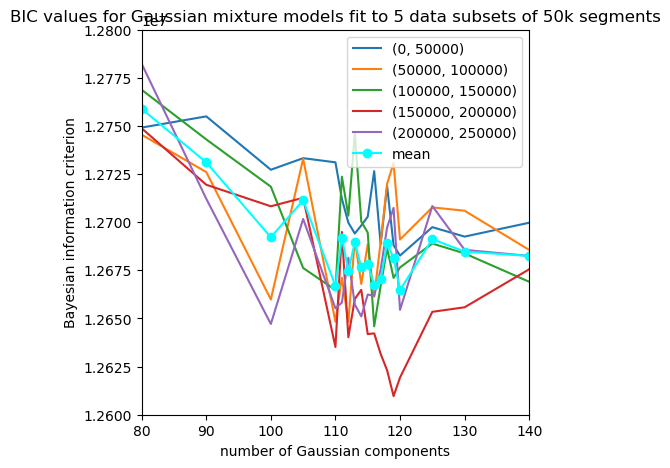

In [15]:
data_subsets = [(0,50000), (50000, 100000), (100000,150000),(150000,200000), (200000, 250000)]
component_no_list = [10,25,50,70,80,90,100,105,110,111,112,113,114,115,116,117,118,119,120,125,130,140,150,200,300]
bics = np.array([
[1.513076963327877596e+07, 1.373494201573342085e+07, 1.310223591745524108e+07, 1.287644645175125077e+07, 1.274916968428172357e+07, 1.275498408091743104e+07, 1.272725532548042759e+07,1.273327056713533960e+07, 1.273110944201433845e+07, 1.271215291174531914e+07, 1.269974317490880564e+07, 1.269413576213483885e+07, 1.269831422006917745e+07, 1.270286540602960251e+07, 1.272652081320444494e+07, 1.268854252120269835e+07, 1.271878362980804965e+07, 1.268805628370952979e+07, 1.268268194913305156e+07,1.269743282206927985e+07, 1.269253136956013553e+07, 1.269973950701179914e+07, 1.271462149632845633e+07, 1.292783153119732440e+07, 1.339544358913458139e+07],
[1.517668787782970630e+07, 1.375655116087884270e+07, 1.301894537214316800e+07, 1.278502388570801169e+07, 1.274546161574119143e+07, 1.272605305849449150e+07, 1.265987061649004370e+07,1.273297575760359690e+07, 1.264832313142326102e+07, 1.267118953481068090e+07, 1.264825245518371463e+07, 1.269095693081272021e+07, 1.266793768580078520e+07, 1.268845881720614433e+07, 1.266137312288295850e+07, 1.268985047919468395e+07, 1.271996471582287923e+07, 1.273072799564955197e+07, 1.269101905685216561e+07,1.270770922392238863e+07, 1.270597545123521052e+07, 1.268562237603535876e+07, 1.274607550342624076e+07, 1.291487403943038359e+07, 1.345206031202976964e+07],
[1.513147027530102991e+07, 1.372693726637074538e+07, 1.312636607615234889e+07, 1.280763613113106042e+07, 1.276878601520187221e+07, 1.274302309312643856e+07, 1.271846136874406226e+07,1.267622275037734210e+07, 1.266478125283669680e+07, 1.272365127627760172e+07, 1.270341859422520176e+07, 1.274606540429916233e+07, 1.270035337163357809e+07, 1.269462134574233554e+07, 1.264591281519959494e+07, 1.266692204580633529e+07, 1.268642471454811655e+07, 1.267109306289681979e+07, 1.267652125702439621e+07,1.268893210948343575e+07, 1.268379260471562855e+07, 1.266906201551120169e+07, 1.271607317416701652e+07, 1.287800719977548718e+07, 1.346352189637094550e+07],
[1.513075834188815393e+07, 1.372975220068028197e+07, 1.305765112890582718e+07, 1.283192171104326844e+07, 1.274878631334129721e+07, 1.271947265357426368e+07, 1.270828195666158944e+07,1.271268768232382834e+07, 1.263517875820080563e+07, 1.269493846218724176e+07, 1.264023021297656186e+07, 1.266014644823007658e+07, 1.266488662979799323e+07, 1.264187690211539157e+07, 1.264225268117410690e+07, 1.263162761737927422e+07, 1.262308756661838479e+07, 1.260968587468877248e+07, 1.261931922283876687e+07,1.265345469640533440e+07, 1.265581449083781987e+07, 1.267555561351045780e+07, 1.271492636046844162e+07, 1.291254769987491146e+07, 1.341979996590973809e+07],
[1.509176813460635953e+07, 1.379692069009907730e+07, 1.309409092464722134e+07, 1.283283915952128172e+07, 1.278231797994311526e+07, 1.271217661442268454e+07, 1.264713496262365766e+07,1.270169793278488889e+07, 1.265528527531241067e+07, 1.265825935773974657e+07, 1.268149589179967158e+07, 1.265726369034977630e+07, 1.265107941581576318e+07, 1.266242553794561140e+07, 1.266178248237481155e+07, 1.267541880952490866e+07, 1.269726119435581937e+07, 1.270745073380917870e+07, 1.265447378898119554e+07,1.270840458273771219e+07, 1.268563932986871898e+07, 1.268250343190071173e+07, 1.269332119142067619e+07, 1.287152213201368600e+07, 1.345943013665321097e+07]
])
minimums = []
for iteration, dataset_bics in enumerate(bics):
    minimums.append(component_no_list[np.argmin(dataset_bics)])
    plt.plot(component_no_list,dataset_bics, label=data_subsets[iteration])
print("Minimum BIC values: ", minimums)
print("Mean of minimum BIC values: ", np.mean(minimums))
print("Minimum of mean BIC values (minimum of cyan): ",component_no_list[np.argmin(np.mean(bics, axis=0))])
plt.plot(component_no_list,np.mean(bics, axis=0), marker = "o", c="cyan", label="mean")
plt.xlim([80,140])
plt.ylim([1.26e7, 1.28e7])
plt.legend()
plt.title("BIC values for Gaussian mixture models fit to 5 data subsets of 50k segments")
plt.xlabel("number of Gaussian components")
plt.ylabel("Bayesian information criterion")
plt.show()